# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Imports here
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torchvision
import time
import json
import itertools
import torch.nn.functional as F
import copy

from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from collections import OrderedDict
from PIL import Image

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). You can [download the data here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip). The dataset is split into two parts, training and validation. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If you use a pre-trained network, you'll also need to make sure the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [2]:
data_dir = 'flower_data'
rescale_size = 256
crop_size = 224

In [3]:
# TODO: Define your transforms for the training and validation sets
# Define a transform to pre-process the training images.

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(rescale_size),                          # smaller edge of image resized to 256
        transforms.RandomCrop(crop_size),                      # get 224x224 crop from random location
        transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
        transforms.ToTensor(),                           # convert the PIL Image to a tensor
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])      # normalize image for pre-trained model
    ]),
    'val': transforms.Compose([
        transforms.Resize(rescale_size),
        transforms.CenterCrop(crop_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


# TODO: Load the datasets with ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

# TODO: Using the image datasets and the transforms, define the dataloaders
dataloaders = {x: 
            torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4) for x in ['train', 'val']}

# print out some data stats
print('Num training images: ', len(image_datasets['train']))
print('Num val images: ', len(image_datasets['val']))

print('Num training image batches: ', len(dataloaders['train']))
print('Num val image batches: ', len(dataloaders['val']))

Num training images:  6552
Num val images:  818
Num training image batches:  205
Num val image batches:  26


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [4]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
class_cat = image_datasets['train'].classes

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [5]:
# Load a pre-trained network 
model = models.densenet201(pretrained=True)
model

/usr/local/lib/python3.5/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

In [6]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if  torch.cuda.is_available():
    print('Training on GPU ...')
else:
    print('Training on CPU ...')

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
    

Training on GPU ...


In [7]:
# Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
num_classes = 102


# Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
num_ftrs = model.classifier.in_features
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(num_ftrs, num_classes)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))    
model.classifier = classifier

model.to(device)

criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
lr = 0.001 
optimizer = optim.Adam(model.classifier.parameters(), lr)

In [8]:
def adjust_learning_rate(optimizer, trk_epoch, lr, decay_lr_every):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    new_lr = lr * (0.1 ** (trk_epoch // decay_lr_every))
    for param_group in optimizer.param_groups:
         param_group['lr'] = new_lr
    return new_lr

In [9]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
# Load checkpoint after running dataset and model arch code
def load_checkpoint(model, filepath):
    checkpoint = torch.load(filepath)
    epoch = checkpoint['epoch']
    lr = checkpoint['lr']
    decay_lr_every = checkpoint['decay_lr_every']
    epoch_dict = checkpoint['epoch_dict']
    train_losses = checkpoint['train_losses_list']
    val_losses = checkpoint['val_losses_list']
    max_accuracy = checkpoint['max_accuracy']
    valid_loss_min = checkpoint['valid_loss_min']
    model.class_to_idx = checkpoint['class_to_idx']
    model.load_state_dict(checkpoint['state_dict'])
    
    return model, epoch, train_losses, val_losses, max_accuracy, lr, decay_lr_every, epoch_dict, valid_loss_min

In [10]:
def train_function(optimizer, model, lr, decay_lr_every=20, starting_epoch=0, n_epochs=100, train_losses=[], 
                   val_losses=[], max_accuracy = 0.0, valid_loss_min=np.Inf, epoch_dict={}):
    
    print_every = 30
    trk_epoch = 0
    current_epoch = starting_epoch
    
    # if epoch_dict is empty make first entry, i.e. starting from epoch 1
    if len(epoch_dict) == 0:
        epoch_dict['1'] = lr
        
    
    # set learning rate if loading model from checkpoint file, i.e. epoch != 1
    if starting_epoch != 0:
        for param_group in optimizer.param_groups:
             param_group['lr'] = lr

    for epoch in range(starting_epoch, n_epochs):
        
#         # Adjust and update lr
#         lr = adjust_learning_rate(optimizer, trk_epoch, lr, decay_lr_every)
#         trk_epoch += 1
        
#         # when learning rate changes make entry on epoch_dict
#         if trk_epoch % decay_lr_every + 1 == 0:
#             epoch_dict[str(epoch)] = lr

        # monitor training loss
        train_loss = 0.0
        val_loss = 0.0
        accuracy = 0
        steps = 0
        tm_sum = 0
        tmp_loss = 0.0
        img_size_sum = 0.0

        model.train() # prep model for training

        for images, labels in dataloaders['train']:

            tic = int(round(time.time() * 1000))  # start timer        
            steps += 1

            # Move images and labels to the default device
            images, labels = images.to(device), labels.to(device)

            # clear the gradients of all optimized variables
            optimizer.zero_grad()

            # forward pass
            log_ps = model(images)

            # calculate the loss
            loss = criterion(log_ps, labels)

            # backward pass: compute gradient of the loss with respect to model weights/parameters
            loss.backward()

            # perform a single optimization step (weight/parameter update)
            optimizer.step()

            # Give more accurate result where last batch has reduced size
            train_loss += loss.item()*images.size(0)
            tmp_loss += loss.item()*images.size(0)
            img_size_sum += images.size(0)

            toc = int(round(time.time() * 1000))
            batch_training_time_secs = ((toc - tic) / 1000)
            tm_sum += batch_training_time_secs

            if steps % print_every == 0:    # print every 'print_every' batches
                    avg_loss = (tmp_loss/img_size_sum)

                    print('Epoch: {}\t Batch: {}\t Avg. Batch Loss: {}\t\t Time (secs): {}'.format(epoch + 1, steps, round(avg_loss,15), round(tm_sum, 2)))
                    tm_sum = 0
                    tmp_loss = 0.0
                    img_size_sum = 0

            if  not torch.cuda.is_available():
                if steps == 100:
                    break

        else:
            # else, meaning at end of loop run       
            # Track the loss and accuracy on the validation set to determine the best hyperparameters
            # Turn off gradients for validation, saves memory and computations

            model.eval()

            for images, labels in dataloaders['val']:

                # Move images and labels to the default device
                images, labels = images.to(device), labels.to(device)
                log_ps = model(images)

                temp_loss = criterion(log_ps, labels)

                val_loss += temp_loss.item()*images.size(0)

                ps = torch.exp(log_ps)

                top_p, top_class = ps.topk(1, dim=1)     # Largest element returned
                equals = top_class == labels.view(*top_class.shape)   
                accuracy += torch.mean(equals.type(torch.FloatTensor)).item()*images.size(0)

            # calculate average loss over an epoch
            train_loss = train_loss/len(dataloaders['train'].dataset)
            val_loss = val_loss/len(dataloaders['val'].dataset)
            accuracy = accuracy/len(dataloaders['val'].dataset)

            train_losses.append(train_loss)
            val_losses.append(val_loss)

            print("Epoch: {}/{}.. ".format(epoch+1, n_epochs),
                  "Training Loss: {:.3f}.. ".format(train_loss),
                  "Val. Loss: {:.3f}.. ".format(val_loss),
                  "Val. Accuracy: {:.3f}".format(accuracy), end=' ') # end=' ', next print will be on same line

            # Exclude 0.0 from max accuracy
            if max_accuracy == 0.0:
                max_accuracy = accuracy
                
            # Exlude np.Inf from min validation
            if valid_loss_min == np.Inf:
                valid_loss_min = val_loss
                
            # Define checkpoint parameters
            def get_checkpoint():    
                return   {'epoch': epoch,
                          'lr': lr,
                          'decay_lr_every':decay_lr_every,
                          'epoch_dict':epoch_dict,
                          'class_to_idx':model.class_to_idx,
                          'train_losses_list':train_losses,
                          'val_losses_list':val_losses,
                          'max_accuracy':max_accuracy,
                          'valid_loss_min':valid_loss_min,
                          'state_dict': model.state_dict()}
            
            
            # save model if validation loss has decreased    
            if val_loss <= valid_loss_min:                
                print('Saving val model.', end=' ')
                valid_loss_min = val_loss
                
                # Save the checkpoint 
                model.class_to_idx = image_datasets['train'].class_to_idx
                torch.save(get_checkpoint(), 'checkpoint_val.pth')

            # save model if accuracy has increased
            if accuracy >= max_accuracy:
                print('Saving accuracy model.')
                max_accuracy = accuracy
                
                # Save the checkpoint 
                model.class_to_idx = image_datasets['train'].class_to_idx
                torch.save(get_checkpoint(), 'checkpoint_acc.pth')
            else:
                # clear buffer
                print("")
                                 
            # Save the latest checkpoint 
            model.class_to_idx = image_datasets['train'].class_to_idx
            torch.save(get_checkpoint(), 'checkpoint.pth')

In [11]:
train_function(optimizer, model, lr, decay_lr_every=20, starting_epoch=0, n_epochs=60, train_losses=[], 
val_losses=[], max_accuracy=0.0, valid_loss_min=np.Inf, epoch_dict={})

Epoch: 1	 Batch: 30	 Avg. Batch Loss: 4.249238634109497		 Time (secs): 12.13
Epoch: 1	 Batch: 60	 Avg. Batch Loss: 3.173480772972107		 Time (secs): 12.02
Epoch: 1	 Batch: 90	 Avg. Batch Loss: 2.259686132272085		 Time (secs): 12.08
Epoch: 1	 Batch: 120	 Avg. Batch Loss: 1.747524356842041		 Time (secs): 12.12
Epoch: 1	 Batch: 150	 Avg. Batch Loss: 1.39228720664978		 Time (secs): 12.14
Epoch: 1	 Batch: 180	 Avg. Batch Loss: 1.143194335699081		 Time (secs): 12.16
Epoch: 1/60..  Training Loss: 2.162..  Val. Loss: 0.732..  Val. Accuracy: 0.913 Saving val model. Saving accuracy model.
Epoch: 2	 Batch: 30	 Avg. Batch Loss: 0.721549093723297		 Time (secs): 12.04
Epoch: 2	 Batch: 60	 Avg. Batch Loss: 0.610094291965167		 Time (secs): 12.04
Epoch: 2	 Batch: 90	 Avg. Batch Loss: 0.549545886119207		 Time (secs): 12.02
Epoch: 2	 Batch: 120	 Avg. Batch Loss: 0.526999264955521		 Time (secs): 12.03
Epoch: 2	 Batch: 150	 Avg. Batch Loss: 0.522514960169792		 Time (secs): 12.03
Epoch: 2	 Batch: 180	 Avg. B

Epoch: 15	 Batch: 90	 Avg. Batch Loss: 0.043951174865166		 Time (secs): 12.04
Epoch: 15	 Batch: 120	 Avg. Batch Loss: 0.040230484493077		 Time (secs): 12.07
Epoch: 15	 Batch: 150	 Avg. Batch Loss: 0.028008484203989		 Time (secs): 12.06
Epoch: 15	 Batch: 180	 Avg. Batch Loss: 0.041023953538388		 Time (secs): 12.07
Epoch: 15/60..  Training Loss: 0.036..  Val. Loss: 0.136..  Val. Accuracy: 0.962 Saving val model. 
Epoch: 16	 Batch: 30	 Avg. Batch Loss: 0.027088826584319		 Time (secs): 12.11
Epoch: 16	 Batch: 60	 Avg. Batch Loss: 0.029848981229588		 Time (secs): 12.14
Epoch: 16	 Batch: 90	 Avg. Batch Loss: 0.030708869205167		 Time (secs): 12.17
Epoch: 16	 Batch: 120	 Avg. Batch Loss: 0.030757511546835		 Time (secs): 12.19
Epoch: 16	 Batch: 150	 Avg. Batch Loss: 0.02887418611596		 Time (secs): 12.2
Epoch: 16	 Batch: 180	 Avg. Batch Loss: 0.031003899670516		 Time (secs): 12.23
Epoch: 16/60..  Training Loss: 0.030..  Val. Loss: 0.138..  Val. Accuracy: 0.967 
Epoch: 17	 Batch: 30	 Avg. Batch L

Epoch: 30	 Batch: 30	 Avg. Batch Loss: 0.017343348404393		 Time (secs): 12.18
Epoch: 30	 Batch: 60	 Avg. Batch Loss: 0.009491671128975		 Time (secs): 12.15
Epoch: 30	 Batch: 90	 Avg. Batch Loss: 0.010749437403865		 Time (secs): 12.1
Epoch: 30	 Batch: 120	 Avg. Batch Loss: 0.013689421090142		 Time (secs): 12.1
Epoch: 30	 Batch: 150	 Avg. Batch Loss: 0.016244776220992		 Time (secs): 12.09
Epoch: 30	 Batch: 180	 Avg. Batch Loss: 0.018651538179256		 Time (secs): 12.12
Epoch: 30/60..  Training Loss: 0.015..  Val. Loss: 0.111..  Val. Accuracy: 0.974 Saving val model. Saving accuracy model.
Epoch: 31	 Batch: 30	 Avg. Batch Loss: 0.018085522290009		 Time (secs): 12.05
Epoch: 31	 Batch: 60	 Avg. Batch Loss: 0.01692089184653		 Time (secs): 12.06
Epoch: 31	 Batch: 90	 Avg. Batch Loss: 0.015309743742303		 Time (secs): 12.08
Epoch: 31	 Batch: 120	 Avg. Batch Loss: 0.013097586500226		 Time (secs): 12.05
Epoch: 31	 Batch: 150	 Avg. Batch Loss: 0.014117241115309		 Time (secs): 12.07
Epoch: 31	 Batch: 

Epoch: 44/60..  Training Loss: 0.009..  Val. Loss: 0.146..  Val. Accuracy: 0.960 
Epoch: 45	 Batch: 30	 Avg. Batch Loss: 0.007496655227927		 Time (secs): 12.15
Epoch: 45	 Batch: 60	 Avg. Batch Loss: 0.00849973767763		 Time (secs): 12.17
Epoch: 45	 Batch: 90	 Avg. Batch Loss: 0.006151858884065		 Time (secs): 12.23
Epoch: 45	 Batch: 120	 Avg. Batch Loss: 0.007560173689853		 Time (secs): 12.24
Epoch: 45	 Batch: 150	 Avg. Batch Loss: 0.005353581528955		 Time (secs): 12.24
Epoch: 45	 Batch: 180	 Avg. Batch Loss: 0.010022518254118		 Time (secs): 12.25
Epoch: 45/60..  Training Loss: 0.007..  Val. Loss: 0.142..  Val. Accuracy: 0.963 
Epoch: 46	 Batch: 30	 Avg. Batch Loss: 0.009115866325252		 Time (secs): 12.23
Epoch: 46	 Batch: 60	 Avg. Batch Loss: 0.004999312296665		 Time (secs): 12.26
Epoch: 46	 Batch: 90	 Avg. Batch Loss: 0.008616829011589		 Time (secs): 12.23
Epoch: 46	 Batch: 120	 Avg. Batch Loss: 0.005412350435896		 Time (secs): 12.25
Epoch: 46	 Batch: 150	 Avg. Batch Loss: 0.00595790291

Epoch: 59	 Batch: 180	 Avg. Batch Loss: 0.008576902289254		 Time (secs): 12.25
Epoch: 59/60..  Training Loss: 0.009..  Val. Loss: 0.169..  Val. Accuracy: 0.960 
Epoch: 60	 Batch: 30	 Avg. Batch Loss: 0.003797947627027		 Time (secs): 12.23
Epoch: 60	 Batch: 60	 Avg. Batch Loss: 0.002039584016893		 Time (secs): 12.2
Epoch: 60	 Batch: 90	 Avg. Batch Loss: 0.004217359338266		 Time (secs): 12.2
Epoch: 60	 Batch: 120	 Avg. Batch Loss: 0.003936489892658		 Time (secs): 12.21
Epoch: 60	 Batch: 150	 Avg. Batch Loss: 0.007784975111523		 Time (secs): 12.22
Epoch: 60	 Batch: 180	 Avg. Batch Loss: 0.008712975634262		 Time (secs): 12.23
Epoch: 60/60..  Training Loss: 0.006..  Val. Loss: 0.143..  Val. Accuracy: 0.968 


In [12]:
# Load the Model with the chosen metric
model, epoch, train_losses, val_losses, max_accuracy, lr, decay_lr_every, epoch_dict, valid_loss_min = load_checkpoint(model, 
                                                                                                        'checkpoint_acc.pth')

In [13]:
# train_function(optimizer, model, lr, decay_lr_every=20, starting_epoch=epoch+1, n_epochs=100, train_losses=train_losses, 
# val_losses=val_losses, max_accuracy=max_accuracy, valid_loss_min=valid_loss_min, epoch_dict=epoch_dict)

In [14]:
# computing validation accuracy for each class

val_loss = 0.0
num_classes = 102
class_correct = list(0. for i in range(num_classes))
class_total = list(0. for i in range(num_classes))

model.eval()

for images, labels in dataloaders['val']:

    # Move images and labels to the default device
    images, labels = images.to(device), labels.to(device)
    log_ps = model(images)

    temp_loss = criterion(log_ps, labels)

    val_loss += temp_loss.item()*images.size(0)

    ps = torch.exp(log_ps)

    top_p, top_class = ps.topk(1, dim=1)     # Largest element returned
    equals = top_class == labels.view(*top_class.shape)
    
    # calculate test accuracy for each object class
    for i in range(images.size(0)):
        label = labels.data[i]
        class_correct[label-1] += equals[i].item()
        class_total[label-1] += 1
    
val_loss = val_loss/len(dataloaders['val'].dataset)
print('Val Loss: {:.6f}\n'.format(val_loss))

for i in range(num_classes):
    if class_total[i] > 0:
        print('Val Accuracy of %3s: %2d%% (%2d/%2d)' % (str(i+1), 100 * class_correct[i] / class_total[i],
                                                                        class_correct[i], class_total[i]))
    else:
        print('Val Accuracy of %3s: N/A (no training example)' % (str(i+1)))

print('\nVal Accuracy (Overall): %2d%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total),
                                                                            np.sum(class_correct), np.sum(class_total)))

Val Loss: 0.110784

Val Accuracy of   1: 100% ( 4/ 4)
Val Accuracy of   2: 100% ( 6/ 6)
Val Accuracy of   3: 80% ( 4/ 5)
Val Accuracy of   4: 100% ( 6/ 6)
Val Accuracy of   5: 100% (10/10)
Val Accuracy of   6: 100% ( 5/ 5)
Val Accuracy of   7: 100% ( 5/ 5)
Val Accuracy of   8: 100% ( 1/ 1)
Val Accuracy of   9: 100% ( 7/ 7)
Val Accuracy of  10: 100% ( 2/ 2)
Val Accuracy of  11: 100% (16/16)
Val Accuracy of  12: 100% (11/11)
Val Accuracy of  13: 75% ( 3/ 4)
Val Accuracy of  14: 100% ( 6/ 6)
Val Accuracy of  15: 85% ( 6/ 7)
Val Accuracy of  16: 100% ( 4/ 4)
Val Accuracy of  17: 100% ( 8/ 8)
Val Accuracy of  18: 100% (12/12)
Val Accuracy of  19: 100% ( 5/ 5)
Val Accuracy of  20: 100% ( 2/ 2)
Val Accuracy of  21: 100% ( 3/ 3)
Val Accuracy of  22: 100% ( 1/ 1)
Val Accuracy of  23: 100% ( 5/ 5)
Val Accuracy of  24: 100% ( 7/ 7)
Val Accuracy of  25: 50% ( 1/ 2)
Val Accuracy of  26: 100% (10/10)
Val Accuracy of  27: 100% ( 2/ 2)
Val Accuracy of  28: 100% ( 3/ 3)
Val Accuracy of  29: 85% ( 6/ 7)

In [15]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

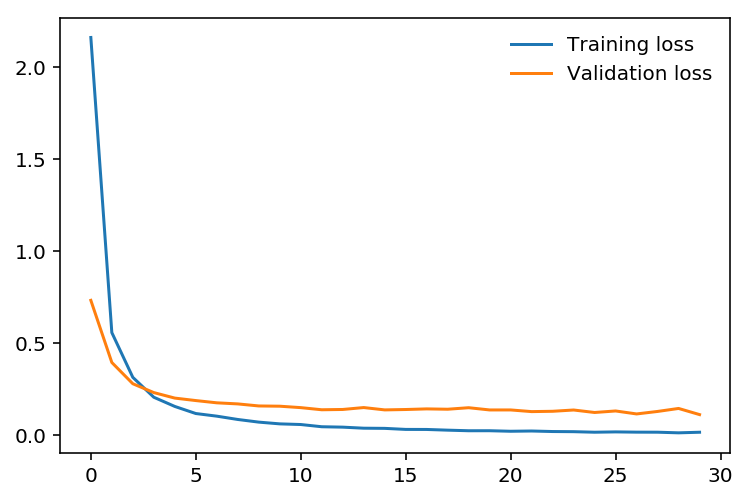

In [16]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [17]:
# # TODO: Save the checkpoint
# model.class_to_idx = image_datasets['train'].class_to_idx
# def get_checkpoint():    
#     return   {'epoch': epoch,
#               'lr': lr,
#               'decay_lr_every':decay_lr_every,
#               'epoch_dict':epoch_dict,
#               'class_to_idx':model.class_to_idx,
#               'train_losses_list':train_losses,
#               'val_losses_list':val_losses,
#               'max_accuracy':max_accuracy,
#               'valid_loss_min':valid_loss_min,
#               'state_dict': model.state_dict()}
# torch.save(get_checkpoint(), 'checkpoint_val.pth')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [18]:
# Load the Model with the chosen metric
# model, epoch, train_losses, val_losses, max_accuracy, lr, decay_lr_every, epoch_dict, valid_loss_min = load_checkpoint(model, 
#                                                                                                       'checkpoint_acc.pth')

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [19]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    # TODO: Process a PIL image for use in a PyTorch model
    img = Image.open(image)
    
    # rescale
    output_size = rescale_size
    w, h = img.size
    if h > w:
        new_h, new_w = output_size * h / w, output_size
    else:
        new_h, new_w = output_size, output_size * w / h
        
    new_h, new_w = int(new_h), int(new_w)
    
    # resize
    img = img.resize((new_w, new_h))
    
    # center crop
    new_height, new_width = crop_size, crop_size

    left = (new_w - new_width)//2
    right = (new_w + new_width)//2
    top = (new_h - new_height)//2   
    bottom = (new_h + new_height)//2

    img = img.crop((left, top, right, bottom))
    
    # Normalize image to range 0, 1
    np_image = np.array(img)
    np_image = np_image/255.0
    
    # swap color axis because
    # numpy image: H x W x C
    # torch image: C X H X W
    tch_image = np_image.transpose((2, 0, 1))
    tch_image[0,:,:] = (tch_image[0,:,:] - 0.485) / 0.229
    tch_image[1,:,:] = (tch_image[1,:,:] - 0.456) / 0.224
    tch_image[2,:,:] = (tch_image[2,:,:] - 0.406) / 0.225
    
    tch_image = torch.from_numpy(tch_image)
    
    return tch_image

In [20]:
image_path = 'flower_data/val/1/image_06739.jpg'
tch_image = process_image(image_path)

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [21]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

def tensor_to_img(image, ax=None, title=None):
    """Imshow for Tensor."""
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    return image

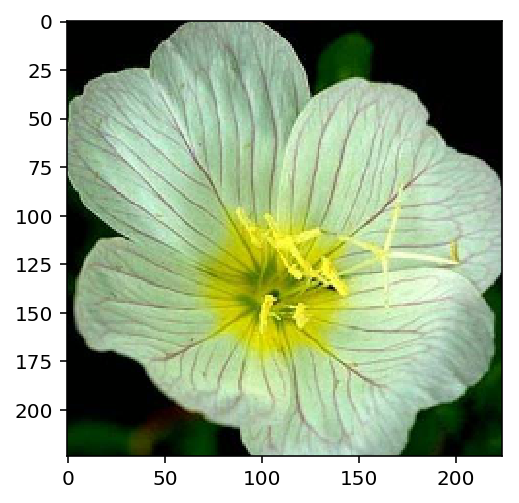

In [22]:
_ = imshow(tch_image)

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [23]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    tch_image = process_image(image_path)
    
    # Add batch dim
    tch_image = tch_image.unsqueeze(0)
    tch_image = tch_image.type(torch.FloatTensor)
    
    # Move images and labels to the default device
    tch_image = tch_image.to(device)
    log_ps = model(tch_image)                
    ps = torch.exp(log_ps)

    top_p, top_idx = ps.topk(topk, dim=1)
    
    # convert idices to classes
    class_to_idx = model.class_to_idx
    idx_to_class = {ii: cl for cl, ii in class_to_idx.items()}
    
    top_p = np.squeeze(top_p.data.numpy()) if not torch.cuda.is_available() else np.squeeze(top_p.cpu().data.numpy())
    top_idx = np.squeeze(top_idx.numpy()) if not torch.cuda.is_available() else np.squeeze(top_idx.cpu().numpy())
    
    top_class = [idx_to_class[idx] for idx in top_idx]    
    top_p = top_p.tolist()
    
    return top_p, top_class

In [24]:
topk=5
top_p, top_class = predict(image_path, model, topk)
print(top_p)
print(top_class)

[0.9999575614929199, 1.0402017323940527e-05, 9.435218998987693e-06, 9.311325811722782e-06, 3.2150339848158183e-06]
['1', '89', '51', '96', '50']


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the validation accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

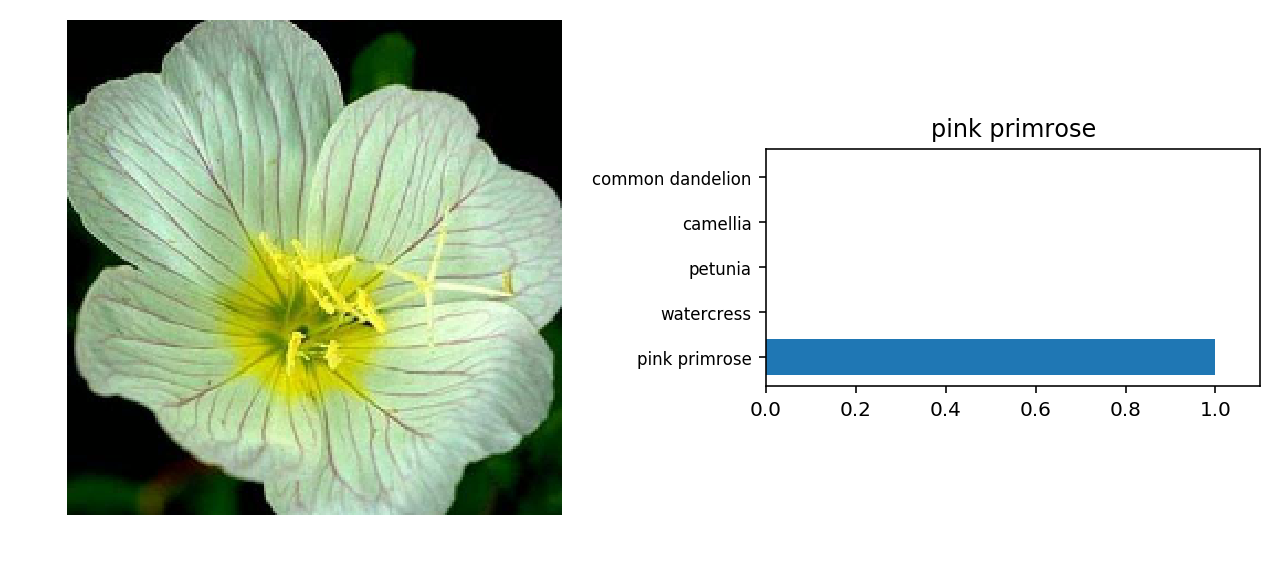

In [25]:
# TODO: Display an image along with the top 5 classes
tch_image = process_image(image_path)
np_image = tensor_to_img(tch_image)
top_p, top_class = predict(image_path, model, topk) 

max_index = top_p.index(max(top_p))

top_p = np.array(top_p)

fig, (ax1, ax2) = plt.subplots(figsize=(9,14), ncols=2)
ax1.imshow(np_image)
ax1.axis('off')
ax2.barh(np.arange(topk), top_p)
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(topk))

top_class_name = [cat_to_name[cat] for cat in top_class]

ax2.set_yticklabels(top_class_name, size='small');
ax2.set_title(cat_to_name[top_class[max_index]])
ax2.set_xlim(0, 1.1)

plt.tight_layout()